In [139]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


In [140]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]

In [147]:
def singe_file(pcd_file_path):
    pcd = o3d.io.read_point_cloud(pcd_file_path)
    # create function that does all the above steps
    # Extract points as a NumPy array
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates with the z-axis as the reference axis
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    rho = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta_degrees = np.degrees(np.arccos(z / rho))

    # Create a DataFrame to store the point cloud data along with theta values
    point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

    # Define the target theta2 values for each transect
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

    # Generate transects with theta2 values around the specified target values with increased range
    transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

    # Rename the transects starting from 1 going to 16
    transect_names = [f'Transect {i}' for i in range(1, 17)]
    transect_dict = dict(zip(transect_names, transects))

    # Check for unassigned points
    unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Remove the 'theta' column from each transect DataFrame
    for name in transect_dict:
        transect_dict[name] = transect_dict[name].drop(columns=['theta'])

    # Select Transect 3 for transformation
    A = 3
    transect_A = transect_dict[f'Transect {A}']

    # Convert transect DataFrame to NumPy array
    transect_xyz = transect_A[['x', 'y', 'z']].values

    # Apply the transformation matrix
    transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

    # Create a DataFrame for the transformed transect
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Compute the translation back offsets for X and Y only
    translation_back = np.eye(4)
    translation_back[0, 3] = -transformation_matrix[0, 3]
    translation_back[1, 3] = -transformation_matrix[1, 3]

    # Apply the translation back to the origin for X and Y
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Coordinates of the two points in the RD-coordinate system
    point1 = np.array([72462.703, 452067.267, 4.101, 1])  # point3
    point2 = np.array([72448.355, 452047.630, 4.075, 1])  # point4

    # Compute the direction vector
    direction = point1 - point2

    # Project the direction vector onto the XY-plane
    direction_xy = direction[:2]  # Only consider the X and Y components

    # Compute the angle to the Y-axis
    angle = np.arctan2(direction_xy[0], direction_xy[1])  # atan2(X, Y)

    # Construct the rotation matrix for rotation around the Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0,              0,             1, 0],
        [0,              0,             0, 1]
    ])

    # Apply the rotation and translation matrix to the two points
    new_point1 = np.dot(translation_back, point1)
    new_point2 = np.dot(translation_back, point2)
    new_point1 = np.dot(rotation_matrix, new_point1)
    new_point2 = np.dot(rotation_matrix, new_point2)

    # Compute the new baseline axis
    baseline_axis = np.mean([new_point1[0], new_point2[0]])

    # Apply the rotation matrix to the point cloud
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_matrix.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

     # remove points between z= [z1,z2], x=[x1,x2]
    transect_transformed_df = transect_transformed_df[(transect_transformed_df['z'] < z1) | (transect_transformed_df['z'] > z2) | (transect_transformed_df['x'] < x1) | (transect_transformed_df['x'] > x2)]

    # Translate the point cloud to align with the baseline axis
    transect_transformed_df['x'] = transect_transformed_df['x'] - baseline_axis + 100
    
    return transect_transformed_df




In [148]:
# Define the transformation matrix gathered from CloudCompare georeferencing
transformation_matrix = np.array([
    [-0.000024980998,  0.000812676153, -0.000583815563,  492.143829345703],
    [ 0.000007067249, -0.000583839603, -0.000813012011,  127.397300720215],
    [-0.001000616350, -0.000024412553,  0.000008833092,    4.558271408081],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])

transformation_matrix[0,3]+=  72000.00 
transformation_matrix[1,3]+=  452000.00
transformation_matrix[3,3]=1

# to be removed area
z1 ,z2,x1,x2= 1.6 , 5.5, -0.9, 0.2 

In [149]:
# Load point clouds
pcd_file1 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0020_12_2024__16_54_27.780.PCD"
pcd_file2 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0021_12_2024__08_21_50.530.PCD"
pcd_file3 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0021_12_2024__14_45_35.530.PCD"
pcd_file4 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__08_21_50.530.PCD"
pcd_file5 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__14_45_35.530.PCD"
pcd_file6 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__02_04_11.030.PCD"
pcd_file7 = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__10_21_50.530.PCD"

pcd_file_sec2 = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0021_12_2024__16_20_30.064.PCD"
pcd_file_sec22 = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0023_12_2024__12_06_30.062.PCD"


# Process each point cloud through the singe_file function
df1 = singe_file(pcd_file1)
df2 = singe_file(pcd_file2)
df3 = singe_file(pcd_file3)
df4 = singe_file(pcd_file4)
df5 = singe_file(pcd_file5)
df6 = singe_file(pcd_file6)
df7 = singe_file(pcd_file7)

df_sec2 = singe_file(pcd_file_sec2)
df_sec22 = singe_file(pcd_file_sec22)

print(df1)
print(df2)
print(df3)
print(df4)
print(df5)

              x         y         z
45    63.107591 -0.209907  1.029813
46    76.082879 -0.116137  1.176950
47    76.528556 -0.112844  1.189487
48    76.959614 -0.109623  1.205561
49    77.361701 -0.106620  1.220420
..          ...       ...       ...
386  110.141601  0.209934  5.119930
387  110.433945  0.214457  5.320805
388  110.798421  0.219732  5.530022
389  111.170899  0.225146  5.746174
390  111.503323  0.230224  5.966599

[259 rows x 3 columns]
              x         y         z
46    68.302235 -0.169708  1.400730
47    77.796745 -0.104087  1.151773
48    78.131611 -0.101600  1.162081
49    78.473048 -0.098996  1.180568
50    78.799208 -0.096495  1.199744
..          ...       ...       ...
385  110.149606  0.210011  5.120136
386  110.439947  0.214515  5.321011
387  110.805419  0.219800  5.530324
388  111.175895  0.225195  5.746434
389  111.514313  0.230333  5.967266

[252 rows x 3 columns]
              x         y         z
48    74.150164 -0.131134  1.037881
49    74.730937 

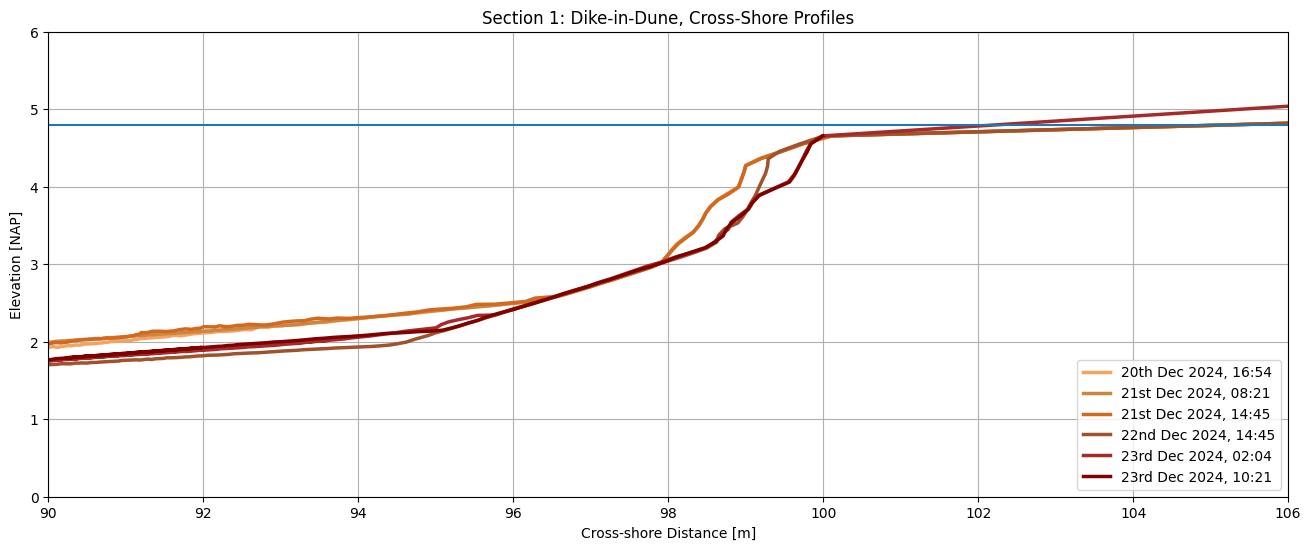

In [153]:
# Plot the transformed transects
plt.figure(figsize=(16, 8))

# Plot each dataframe
plt.plot(df1['x'], df1['z'], color='sandybrown', linewidth=2.5, label='20th Dec 2024, 16:54')
plt.plot(df2['x'], df2['z'], color='peru', linewidth=2.5, label='21st Dec 2024, 08:21')
plt.plot(df3['x'], df3['z'], color='chocolate', linewidth=2.5, label='21st Dec 2024, 14:45')
plt.plot(df5['x'], df5['z'], color='sienna', linewidth=2.5, label='22nd Dec 2024, 14:45')
plt.plot(df6['x'], df6['z'], color='brown', linewidth=2.5, label='23rd Dec 2024, 02:04')
plt.plot(df7['x'], df7['z'], color='maroon', linewidth=2.5, label='23rd Dec 2024, 10:21')

plt.axhline(y=4.8)
plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-Shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.xlim(90, 106)
plt.ylim(0, 6)
plt.show()
